Importation of modules and functions
===

In [1]:
# Modules
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import sys
import datetime
import random
import warnings

# Functions
sys.path.insert(0, './implementations/')
from implementations import *
from preprocessing import *
from pca import *
from plot import *
from helpers import *

# Autoreload
%load_ext autoreload
%autoreload 2

# Set random seed
np.random.seed(1)

Training data loading
===

In [2]:
(labels_raw, data_raw, ids_raw) = load_csv_data("data/train.csv")

Data filtering and normalization 
===

In [6]:
# Splitting data
X_train, y_train, X_test, y_test = split_data(data_raw, labels_raw)

# Filtering missing values and outliers
X_train, X_test, y_train = process_data(X_train, X_test, y_train, ids_raw, sample_filtering = False, feature_filtering = False, replace = 'mean',remove_outlier = True)

# Standardization
# X_train, means, variance = standardize(X_train)
# X_test = standardize_test(X_test, means, variance)

# Build interaction terms
X_train_int = build_interact_terms(X_train)
X_test_int = build_interact_terms(X_test)

# Build polynomial of degree 2
X_train_poly = build_poly(X_train, 2)
X_test_poly = build_poly(X_test, 2)

# Combine polynomial and int term
data_train = np.c_[X_train_poly, X_train_int]
data_test = np.c_[X_test_poly, X_test_int]

# Perform PCA
eigVal, eigVec, sumEigVal = PCA(data_train, threshold = 0.9)
data = data_train.dot(eigVec)
data_t = data_test.dot(eigVec)
print("we have reduce the number of feature with PCA to {0}".format(eigVec.shape[1]))


The original dimensions of the training data set was 200000 samples and 30 columns
 After feature and sample filtering, there are 200000 samples and 30 columns
we have reduce the number of feature with PCA to 182


Build data into matrix form
===

In [7]:
y, tx = build_model_data(data, y_train)
y_t, tx_t = build_model_data(data_t,y_test)

Logistic regression using Newton's method
===

25/75	 train acc : 0.81205 	 | test acc : 0.81038
50/75	 train acc : 0.8174 	 | test acc : 0.8147
75/75	 train acc : 0.817985 	 | test acc : 0.81534


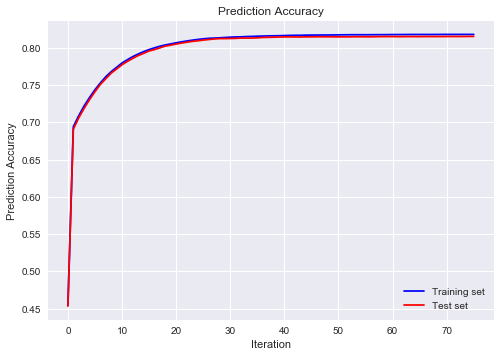

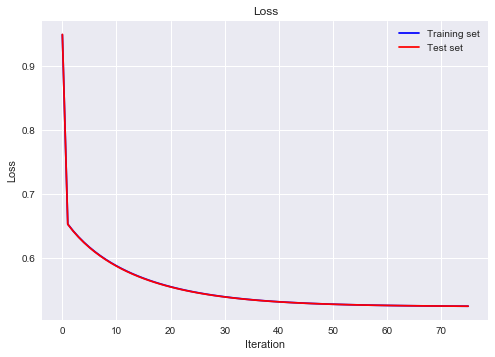

In [8]:
initial_w = np.ones(tx.shape[1])
losses_tr, losses_ts, acc_tr, acc_ts, w = logistic_hessian(y, tx, y_t, tx_t, initial_w, 0.07, 500, 75) # fit model, retrieve parameters 

plot_acc(acc_tr, acc_ts)

plot_loss(losses_tr, losses_ts)


25/75	 train acc : 0.81013 	 | test acc : 0.8086


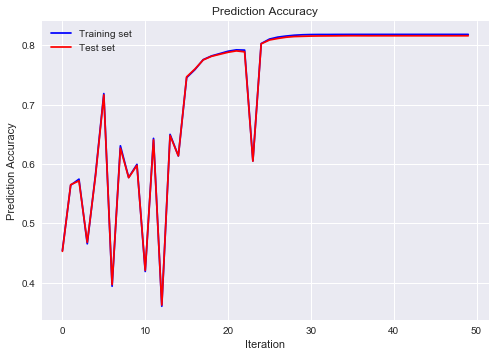

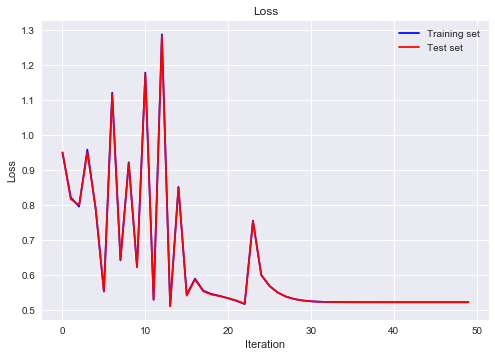

In [65]:
initial_w = np.ones(tx.shape[1])
losses_tr, losses_ts, acc_tr, acc_ts, w = logistic_hessian(y, tx, y_t, tx_t, initial_w, 0.5, 500, 75, momentum = 0) # fit model, retrieve parameters 

plot_acc(acc_tr, acc_ts)

plot_loss(losses_tr, losses_ts)


Grid search for best paramaters
===

In [13]:
X_train, y_train, X_test, y_test = split_data(data_raw, labels_raw)

# Filtering missing values and outliers
X_train, X_test, y_train = process_data(X_train, X_test, y_train, ids_raw, sample_filtering = False, feature_filtering = False, replace = 'median',remove_outlier = True)

# Build interaction terms
data_tr_int = build_interact_terms(X_train)
data_ts_int = build_interact_terms(X_test)

# Build polynomial of degree 3
data_tr_poly = build_poly(X_train, 4)
data_ts_poly = build_poly(X_test, 4)

# Build log 
data_tr_log = np.log(abs(X_train)+1)
data_ts_log = np.log(abs(X_test)+1)


# Combine polynomial and int term
data_train = np.c_[data_tr_poly, data_tr_int, data_tr_log]
data_test = np.c_[data_ts_poly, data_ts_int, data_ts_log]

# Perform PCA
eigVal, eigVec, sumEigVal = PCA(data_train, threshold = 0.98)
data = data_train.dot(eigVec)
data_t = data_test.dot(eigVec)
print("we have reduce the number of feature with PCA to {0}".format(eigVec.shape[1]))

y, tx = build_model_data(data, y_train)
y_t, tx_t = build_model_data(data_t,y_test)

The original dimensions of the training data set was 200000 samples and 30 columns
 After feature and sample filtering, there are 200000 samples and 30 columns
we have reduce the number of feature with PCA to 81


In [14]:
num_iter = 150
lr = np.arange(0.05,0.1,0.005)
lamb = np.logspace(-3,3,7)

initial_w = np.ones(tx.shape[1])

best_gamma = 0
best_lambda = 0
best_acc = 0
grid_acc = np.zeros([len(lr),len(lamb)])

for g in range(len(lr)):
    for l in range(len(lamb)):
        grid_acc[g,l] = Grid_Search_logistic(y, tx, y_t, tx_t, initial_w, gamma=lr[g], lam=lamb[l], max_iters = num_iter, momentum = 0)
        print("gamma: {0} \t| lambda: {1} \t| test acc: {2}".format(lr[g],lamb[l], grid_acc[g,l]))
        if (grid_acc[g,l] > best_acc):
            best_acc = grid_acc[g,l]
            best_gamma = lr[g]
            best_lambda = lamb[l]

file = "grid_search_logistic_test_acc.npy"
np.save(file, grid_acc)


gamma: 0.05 	| lambda: 0.001 	| test acc: 0.76762
gamma: 0.05 	| lambda: 0.01 	| test acc: 0.767
gamma: 0.05 	| lambda: 0.1 	| test acc: 0.76272
gamma: 0.05 	| lambda: 1.0 	| test acc: 0.72088
gamma: 0.05 	| lambda: 10.0 	| test acc: 0.5965
gamma: 0.05 	| lambda: 100.0 	| test acc: 0.60826
gamma: 0.05 	| lambda: 1000.0 	| test acc: 0.5978
gamma: 0.060000000000000005 	| lambda: 0.001 	| test acc: 0.76754
gamma: 0.060000000000000005 	| lambda: 0.01 	| test acc: 0.76742
gamma: 0.060000000000000005 	| lambda: 0.1 	| test acc: 0.76598
gamma: 0.060000000000000005 	| lambda: 1.0 	| test acc: 0.71656
gamma: 0.060000000000000005 	| lambda: 10.0 	| test acc: 0.6131
gamma: 0.060000000000000005 	| lambda: 100.0 	| test acc: 0.62436
gamma: 0.060000000000000005 	| lambda: 1000.0 	| test acc: 0.60946
gamma: 0.07 	| lambda: 0.001 	| test acc: 0.76734
gamma: 0.07 	| lambda: 0.01 	| test acc: 0.76708
gamma: 0.07 	| lambda: 0.1 	| test acc: 0.76636
gamma: 0.07 	| lambda: 1.0 	| test acc: 0.72728
gamma: 0

In [18]:
best_gamma
best_lambda

0.01

Text(34,0.5,'gamma')

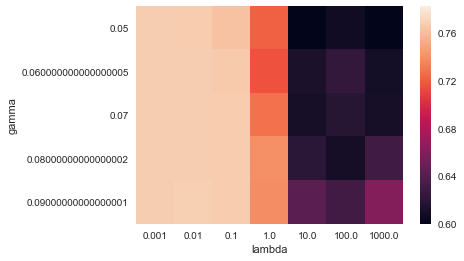

In [15]:
# grid_acc = np.load(file)
import seaborn as sns; sns.set()
ax = sns.heatmap(grid_acc,xticklabels=lamb, yticklabels=lr,vmin= 0.6, vmax=0.782)
ax.set_xlabel('lambda')
ax.set_ylabel('gamma')


In [4]:
X_train, y_train, X_test, y_test = split_data(data_raw, labels_raw)

# Filtering missing values and outliers
X_train, X_test, y_train = process_data(X_train, X_test, y_train, ids_raw, sample_filtering = False, feature_filtering = False, replace = 'mean',remove_outlier = True)

# Build interaction terms
data_tr_int = build_interact_terms(X_train)
data_ts_int = build_interact_terms(X_test)

# Build polynomial of degree 3
data_tr_poly = build_poly(X_train, 4)
data_ts_poly = build_poly(X_test, 4)

# Build log 
data_tr_log = np.log(abs(X_train)+1)
data_ts_log = np.log(abs(X_test)+1)


# Combine polynomial and int term
data_train = np.c_[data_tr_poly, data_tr_int, data_tr_log]
data_test = np.c_[data_ts_poly, data_ts_int, data_ts_log]

# Perform PCA
eigVal, eigVec, sumEigVal = PCA(data_train, threshold = 0.98)
data = data_train.dot(eigVec)
data_t = data_test.dot(eigVec)
print("we have reduce the number of feature with PCA to {0}".format(eigVec.shape[1]))

y, tx = build_model_data(data, y_train)
y_t, tx_t = build_model_data(data_t,y_test)

The original dimensions of the training data set was 200000 samples and 30 columns
 After feature and sample filtering, there are 200000 samples and 30 columns
we have reduce the number of feature with PCA to 82


In [15]:
print(np.logspace(-3,3,7))

[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]


In [6]:
num_iter = 100
lr = np.arange(0.05,0.06, 0.07)
lamb = np.logspace(-3,3,7)

initial_w = np.ones(tx.shape[1])

best_gamma = 0
best_lambda = 0
best_acc = 0
grid_acc = np.zeros([len(lr),len(lamb)])

for g in range(len(lr)):
    for l in range(len(lamb)):
        grid_acc[g,l] = Grid_Search_logistic(y, tx, y_t, tx_t, initial_w, gamma=lr[g], lam=lamb[l], max_iters = num_iter, momentum = 0)
        print("gamma: {0} \t| lambda: {1} \t| test acc: {2}".format(lr[g],lamb[l], grid_acc[g,l]))
        if (grid_acc[g,l] > best_acc):
            best_acc = grid_acc[g,l]
            best_gamma = lr[g]
            best_lambda = lamb[l]

file = "grid_search_logistic_test_acc_mean.npy"
np.save(file, grid_acc)


./implementations\implementations.py:371: ComplexWarning: Casting complex values to real discards the imaginary part
  sig[idx] = 1. / (1 + np.exp(-z[idx]))
./implementations\implementations.py:372: ComplexWarning: Casting complex values to real discards the imaginary part
  sig[~idx] = np.exp(z[~idx]) / (1. + np.exp(z[~idx]))


gamma: 0.05 	| lambda: 0.01 	| test acc: 0.75784
gamma: 0.05 	| lambda: 0.1 	| test acc: 0.75408
gamma: 0.05 	| lambda: 1.0 	| test acc: 0.7322
gamma: 0.05 	| lambda: 10.0 	| test acc: 0.5991
gamma: 0.05 	| lambda: 100.0 	| test acc: 0.79702
gamma: 0.07 	| lambda: 0.01 	| test acc: 0.75004
gamma: 0.07 	| lambda: 0.1 	| test acc: 0.76558
gamma: 0.07 	| lambda: 1.0 	| test acc: 0.7357
gamma: 0.07 	| lambda: 10.0 	| test acc: 0.61202
gamma: 0.07 	| lambda: 100.0 	| test acc: 0.6415
gamma: 0.09000000000000001 	| lambda: 0.01 	| test acc: 0.76724
gamma: 0.09000000000000001 	| lambda: 0.1 	| test acc: 0.76246
gamma: 0.09000000000000001 	| lambda: 1.0 	| test acc: 0.74958
gamma: 0.09000000000000001 	| lambda: 10.0 	| test acc: 0.65198
gamma: 0.09000000000000001 	| lambda: 100.0 	| test acc: 0.63006


Text(34,0.5,'gamma')

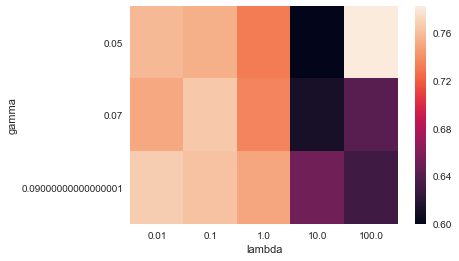

In [7]:
# grid_acc = np.load(file)
import seaborn as sns; sns.set()
ax = sns.heatmap(grid_acc,xticklabels=lamb, yticklabels=lr,vmin= 0.6, vmax=0.782)
ax.set_xlabel('lambda')
ax.set_ylabel('gamma')


Kaggle 
====

Testing data loading
===

In [8]:
(labels_t, data_raw_t, ids_t) = load_csv_data("data/test.csv")

Data filtering and normalization (both datasets entirely)
===

In [9]:
# Filtering missing values and outliers
data_tr, data_ts, y_tr = process_data(data_raw, data_raw_t, labels_raw, ids_raw, sample_filtering = False, feature_filtering = False, replace = 'mean',remove_outlier = True)

# # Standardization
# data_tr, means, variance = standardize(data_tr)
# data_ts = standardize_test(data_ts, means, variance)

# Build interaction terms
data_tr_int = build_interact_terms(data_tr)
data_ts_int = build_interact_terms(data_ts)

# Build polynomial of degree 3
data_tr_poly = build_poly(data_tr, 4)
data_ts_poly = build_poly(data_ts, 4)

# Build log 
data_tr_log = np.log(abs(data_tr)+1)
data_ts_log = np.log(abs(data_ts)+1)

# data_tr_1_ = 1./data_tr_poly
# data_ts_1_ = 1./data_ts_poly

# Combine polynomial and int term
data_train = np.c_[data_tr_poly, data_tr_int, data_tr_log]
data_test = np.c_[data_ts_poly, data_ts_int, data_ts_log]

# Perform PCA
eigVal, eigVec, sumEigVal = PCA(data_train, threshold = 0.9999)
data = data_train.dot(eigVec)
data_t = data_test.dot(eigVec)
print("we have reduce the number of feature with PCA to {0}".format(eigVec.shape[1]))

The original dimensions of the training data set was 250000 samples and 30 columns
 After feature and sample filtering, there are 250000 samples and 30 columns
we have reduce the number of feature with PCA to 507


Build data into matrix form
===

In [10]:
y, tx = build_model_data(data, y_tr)
y_t, tx_t = build_model_data(data_t,labels_t)

Logistic regression using Newton's method
===

In [17]:
best_gamma = 0.05
best_lambda = 500
initial_w = np.zeros(tx.shape[1])
losses, losses_t, acc, acc_t, w = logistic_hessian(y, tx, y_t, tx_t, initial_w, best_gamma, best_lambda, 200) # fit model, retrieve parameters 

25/200	 train acc : 0.827496 	 | test acc : 0.3106726406892886
50/200	 train acc : 0.83064 	 | test acc : 0.31542065120600876


KeyboardInterrupt: 

Kaggle submission
===

In [71]:
pred_t = predict_labels_logistic(w, tx_t, 0.5)

name = "pred_LR_05_LM_100.csv"
create_csv_submission(ids_t, pred_t, name)
